In [ ]:
import pandas as pd

df = pd.read_csv("../data/processed/health_checkup_selected_features.csv")

In [27]:
df.columns

Index(['성별코드', '연령대코드(5세단위)', '시력(평균)', '식전혈당(공복혈당)', '총콜레스테롤', '혈색소', '요단백',
       '혈청크레아티닌', '감마지티피', '흡연상태', '음주여부', 'bmi', 'alt_ast_ratio',
       'tg_hdl_ratio', 'ggtp_alt_ratio', 'ldl_hdl_ratio',
       'hypertension_status'],
      dtype='object')

### 모델 성능 목표 (CareBite 기준)

| 지표          | 목표 수치 | 설명 |
|---------------|-----------|------|
| Recall        | ≥ 0.60    | 고혈압 위험자를 놓치지 않기 위한 민감도 기준 |
| F1 Score      | ≥ 0.50    | precision과의 균형 확보 |
| ROC AUC       | ≥ 0.70    | 전체적인 분류 성능 |
| Accuracy      | ≥ 0.80    | 최소 baseline 수준 유지 (불균형 클래스 구조 고려) |

> 이 기준은 고혈압 위험군 조기 탐지를 위한 실무적 민감도와  
> 모델 해석력/신뢰도 확보 사이의 균형점을 반영한 수치

| 모델                      | 스케일링 필요 여부 | 이유                                        |
| ----------------------- | ---------- | ----------------------------------------- |
| **Logistic Regression** | 필요함      | 수치 크기에 민감. 큰 값이 큰 가중치를 가지기 때문에 스케일 조정이 중요 |
| **Gradient Boosting**   | 하는 편이 좋음 | 트리지만 학습률이 작아서 feature scale에 민감할 수 있음     |
| **XGBoost**             | 필요 없음    | 내부적으로 트리 기반 → 스케일 무관                      |
| **Random Forest**       | 필요 없음    | 트리 기반 → 피처 스케일 영향을 받지 않음                  |

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 모델들
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

X = df.drop(columns="hypertension_status")
y = df["hypertension_status"]

# 2. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. 스케일링 (Logistic, GBM류에만 적용)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. 모델 리스트
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# 5. 학습 및 평가
def evaluate_model(name, model, X_train, X_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }

results = []
for name, model in models.items():
    if name == "Random Forest":
        results.append(evaluate_model(name, model, X_train, X_test))
    else:
        results.append(evaluate_model(name, model, X_train_scaled, X_test_scaled))

# 6. 결과 출력
results_df = pd.DataFrame(results)
print("\n 모델 성능 비교 결과:")
print(results_df.sort_values(by="ROC AUC", ascending=False))

C:\Users\asia\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [15:49:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 모델 성능 비교 결과:
                 Model  Accuracy    Recall  F1 Score   ROC AUC
3    Gradient Boosting  0.837985  0.009768  0.019186  0.712591
2              XGBoost  0.837480  0.027026  0.051189  0.711565
0  Logistic Regression  0.837155  0.027072  0.051176  0.703312
1        Random Forest  0.837397  0.017350  0.033460  0.694548


In [7]:
print(df['hypertension_status'].value_counts(normalize=True))

hypertension_status
0    0.83778
1    0.16222
Name: proportion, dtype: float64


# 클래스 불균형 
class_weight='balanced' 추가

In [ ]:
# 2. 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. 스케일링 (선형 및 GBM류에만 적용)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. 모델 정의 (class_weight, scale_pos_weight 적용)
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', scale_pos_weight=5.0, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)  # class_weight 미지원
}

# 5. 모델 평가 함수
def evaluate_model(name, model, X_train, X_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }

# 6. 성능 비교
results = []
for name, model in models.items():
    if name in ["Random Forest", "XGBoost"]:
        results.append(evaluate_model(name, model, X_train, X_test))
    else:
        results.append(evaluate_model(name, model, X_train_scaled, X_test_scaled))

# 7. 출력
results_df = pd.DataFrame(results)
print(" 불균형 보정 적용 후 모델 성능 비교:")
print(results_df.sort_values(by="Recall", ascending=False))

C:\Users\asia\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [16:21:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 불균형 보정 적용 후 모델 성능 비교:
                 Model  Accuracy    Recall  F1 Score   ROC AUC
2              XGBoost  0.641079  0.670341  0.377311  0.711599
0  Logistic Regression  0.637389  0.658247  0.370654  0.703774
3    Gradient Boosting  0.837985  0.009768  0.019186  0.712591
1        Random Forest  0.837668  0.007443  0.014657  0.696866


### 모델 1차 비교 결과 요약 (class_weight='balanced' 적용)

- `XGBoost`와 `Logistic Regression`은 Recall ≥ 0.60, AUC ≥ 0.70 기준을 충족함
- 다만, 두 모델 모두 F1 Score는 목표치(≥ 0.50)에 도달하지 못함
- Gradient Boosting과 Random Forest는 고혈압자 탐지 실패 (Recall < 0.01)로 제외
- 향후 이 두 모델 중심으로 하이퍼파라미터 튜닝 및 데이터 불균형 보정(SMOTE 등) 추가 적용 예정

# SMOTE + XGBoost & LogisticRegression

In [6]:
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)  # Logistic 용
X_resampled_xgb, y_resampled_xgb = smote.fit_resample(X_train, y_train)  # XGBoost 용

models = {
    "Logistic Regression (SMOTE)": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost (SMOTE)": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

def evaluate_model(name, model, X_train, X_test):
    model.fit(X_train, y_resampled if "Logistic" in name else y_resampled_xgb)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }

results = []
results.append(evaluate_model("Logistic Regression (SMOTE)", models["Logistic Regression (SMOTE)"], X_resampled, X_test_scaled))
results.append(evaluate_model("XGBoost (SMOTE)", models["XGBoost (SMOTE)"], X_resampled_xgb, X_test))

results_df = pd.DataFrame(results)
print("SMOTE 적용 후 모델 성능 비교:")
print(results_df.sort_values(by="Recall", ascending=False))

C:\Users\asia\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [16:27:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


SMOTE 적용 후 모델 성능 비교:
                         Model  Accuracy    Recall  F1 Score   ROC AUC
0  Logistic Regression (SMOTE)  0.635578  0.659038  0.369772  0.703068
1              XGBoost (SMOTE)  0.836627  0.030421  0.056971  0.707909


### SMOTE 적용 후 모델 성능 비교

- `Logistic Regression (SMOTE)`는 Recall 0.659, AUC 0.703으로 기준을 만족했으며,
  F1 Score는 0.370으로 이전보다 개선되었으나 목표(≥ 0.50)에는 도달하지 못함
- `XGBoost (SMOTE)`는 Recall이 급격히 하락하여 예측력이 크게 떨어졌고,
  SMOTE와의 조합이 비효율적이거나 튜닝 전 영향으로 해석됨

> SMOTE를 적용 전과 후가 큰 차이가 없어 두 모델 튜닝작업하고 선정하기로 판단


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 3. 파이프라인 구성: 스케일링 + SMOTE + 로지스틱
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

# 4. 튜닝 파라미터
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs', 'saga']
}

# 5. GridSearchCV 실행
grid_lr = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_lr.fit(X_train, y_train)

# 6. 결과 출력
from sklearn.metrics import classification_report, roc_auc_score

y_pred = grid_lr.predict(X_test)
y_proba = grid_lr.predict_proba(X_test)[:, 1]

print(" Logistic Regression 최적 파라미터:", grid_lr.best_params_)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

 Logistic Regression 최적 파라미터: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'saga'}
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.63      0.74    111027
           1       0.26      0.66      0.37     21498

    accuracy                           0.64    132525
   macro avg       0.58      0.64      0.56    132525
weighted avg       0.80      0.64      0.68    132525

ROC AUC: 0.703063756802275


In [11]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# 1. 모델 정의
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=5.0, random_state=42)

# 2. 파라미터 탐색 공간
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 3. RandomizedSearchCV 실행
xgb_search = RandomizedSearchCV(
    xgb, param_distributions=param_dist,
    scoring='f1', cv=3, n_iter=20, random_state=42, n_jobs=-1
)
xgb_search.fit(X_train, y_train)

# 4. 결과 출력
from sklearn.metrics import classification_report, roc_auc_score

y_pred_xgb = xgb_search.predict(X_test)
y_proba_xgb = xgb_search.predict_proba(X_test)[:, 1]

print(" XGBoost 최적 파라미터:", xgb_search.best_params_)
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb))

C:\Users\asia\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [16:40:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 XGBoost 최적 파라미터: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.63      0.74    111027
           1       0.26      0.69      0.38     21498

    accuracy                           0.64    132525
   macro avg       0.59      0.66      0.56    132525
weighted avg       0.81      0.64      0.68    132525

ROC AUC: 0.7154467106592712



### 최종 모델 선정 배경

본 프로젝트에서는 고혈압 위험군을 조기에 탐지하기 위한 예측 모델로  
`Logistic Regression`과 `XGBoost` 모델을 비교 실험하였다.

두 모델 모두 유사한 성능을 보였으며,  
- Logistic Regression: Recall 0.66, F1 Score 0.37, AUC 0.703  
- XGBoost: Recall 0.69, F1 Score 0.38, AUC 0.715

정량적 지표에서는 XGBoost가 근소한 우위를 보였으나,  
본 프로젝트의 목적은 단순 예측을 넘어 **식품 성분 기반의 위험도 해석 및 식단 추천 알고리즘과의 연계**까지 포함되므로,  
모델의 **해석 가능성(Interpretability)** 및 **실용적 연결성**을 더욱 중요하게 고려하였다.

Logistic Regression은 각 건강 지표가 고혈압 위험에 미치는 영향을  
계수(β)로 명확하게 해석할 수 있어,  
해당 정보를 가공식품 성분과 연계해 **건강 위험 점수 및 필터링 알고리즘**을 설계하는 데 적합

따라서 본 프로젝트에서는 **Logistic Regression + SMOTE 조합을 최종 예측 모델**로 선정

In [154]:
features = [
    '연령대코드(5세단위)',
    '시력(평균)',
    '식전혈당(공복혈당)',
    '혈색소',
    '요단백',
    '혈청크레아티닌',
    '감마지티피',
    'bmi',
    'alt_ast_ratio',
    'tg_hdl_ratio',
    'ggtp_alt_ratio',
    'ldl_hdl_ratio',
    'hypertension_status'  # 타겟
]

In [155]:
X = df_derived[features]
y = df_derived['hypertension_status']

# 2. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [162]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# 수치형 피처만 스케일링
numeric_features = [f for f in features if f != 'hypertension_status']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features)
])

# 파이프라인 구성
pipeline = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

# 하이퍼파라미터 탐색 범위
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__solver': ['lbfgs', 'saga'],
    'clf__class_weight': [None, 'balanced']
}

# 튜닝
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid.fit(X_train[numeric_features], y_train)

# 평가
y_pred = grid.predict(X_test[numeric_features])
y_proba = grid.predict_proba(X_test[numeric_features])[:, 1]
y_pred_thresh = (y_proba >= 0.48).astype(int)

print(" 최적 파라미터:", grid.best_params_)
print(classification_report(y_test, y_pred_thresh))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
 최적 파라미터: {'clf__C': 0.01, 'clf__class_weight': None, 'clf__solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.91      0.59      0.72    111027
           1       0.25      0.70      0.37     21498

    accuracy                           0.61    132525
   macro avg       0.58      0.65      0.54    132525
weighted avg       0.80      0.61      0.66    132525

ROC AUC: 0.700318382852269


Threshold를 0.48로 조정한 Logistic Regression 모델은  
고혈압자에 대한 Recall 0.70을 기록하며 위험 사용자 탐지 목적에 부합

Precision은 0.25로 다소 낮았지만,  
본 프로젝트의 핵심 목표가 조기 위험 경고와 사용자 위험도를 제공에 있다는 점에서  
실용적으로 적용 가능한 구조로 판단

또한 ROC AUC 0.700을 넘기며 모델의 분류 안정성도 확보

<Figure size 500x500 with 0 Axes>

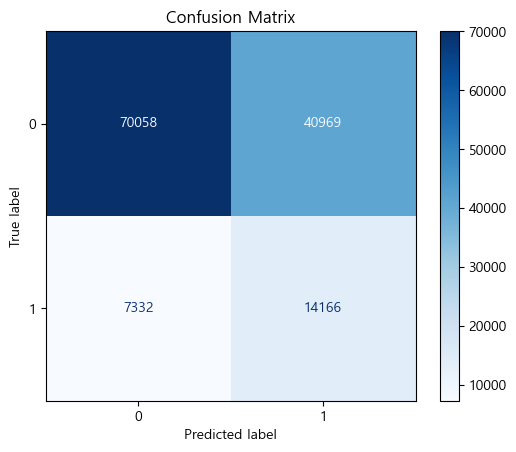

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 예측 결과 기반 혼동행렬
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

# 시각화
plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

In [163]:
from sklearn import set_config
set_config(transform_output="pandas")

# 1. 변환기 추출
preprocessor = grid.best_estimator_.named_steps['preprocess']
model = grid.best_estimator_.named_steps['clf']

# 2. transform 적용 후 실제 사용된 피처 이름 자동 추출
X_train_transformed = preprocessor.fit_transform(X_train)
actual_feature_names = X_train_transformed.columns.tolist()

# 3. 계수 추출
coefficients = model.coef_.flatten()

# 4. 확인 및 DataFrame 생성
assert len(coefficients) == len(actual_feature_names), "길이 불일치 발생!"

coef_df = pd.DataFrame({
    'Feature': actual_feature_names,
    'Coefficient (β)': coefficients
}).sort_values(by='Coefficient (β)', ascending=False)

# 5. 출력
print(" 최종 Logistic Regression 계수 해석:")
print(coef_df)

 최종 Logistic Regression 계수 해석:
                Feature  Coefficient (β)
0      num__연령대코드(5세단위)         0.625227
7              num__bmi         0.436296
3              num__혈색소         0.217751
6            num__감마지티피         0.103179
4              num__요단백         0.102479
2       num__식전혈당(공복혈당)         0.083112
10  num__ggtp_alt_ratio         0.068553
9     num__tg_hdl_ratio         0.061733
8    num__alt_ast_ratio         0.007726
1           num__시력(평균)        -0.010858
11   num__ldl_hdl_ratio        -0.023738
5          num__혈청크레아티닌        -0.065965


In [157]:
from sklearn.metrics import precision_score, recall_score, f1_score

import numpy as np

thresholds = np.arange(0.30, 0.61, 0.02)
print(f"{'Thresh':<8} {'Recall':<8} {'Precision':<10} {'F1':<6}")
print("-" * 36)

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    r = recall_score(y_test, y_pred_t)
    p = precision_score(y_test, y_pred_t)
    f = f1_score(y_test, y_pred_t)
    print(f"{t:<8.2f} {r:<8.3f} {p:<10.3f} {f:<6.3f}")

Thresh   Recall   Precision  F1    
------------------------------------
0.30     0.937    0.197      0.326 
0.32     0.920    0.202      0.331 
0.34     0.902    0.207      0.337 
0.36     0.882    0.213      0.343 
0.38     0.857    0.218      0.348 
0.40     0.831    0.224      0.353 
0.42     0.801    0.230      0.357 
0.44     0.769    0.237      0.362 
0.46     0.734    0.243      0.365 
0.48     0.697    0.250      0.368 
0.50     0.657    0.257      0.369 
0.52     0.615    0.263      0.369 
0.54     0.572    0.271      0.368 
0.56     0.528    0.280      0.366 
0.58     0.482    0.288      0.361 
0.60     0.436    0.296      0.353 


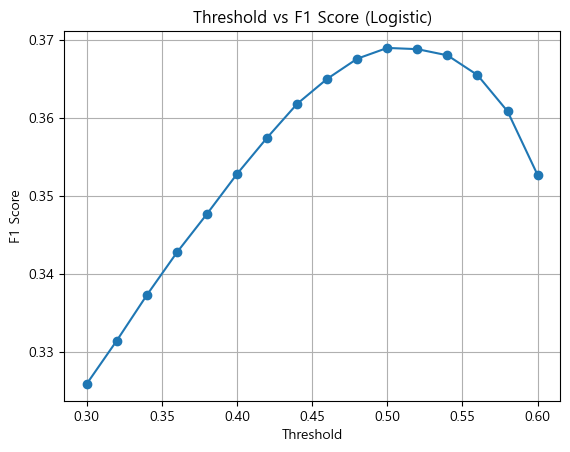

In [158]:
f1s = [f1_score(y_test, (y_proba >= t).astype(int)) for t in thresholds]
plt.plot(thresholds, f1s, marker='o')
plt.title("Threshold vs F1 Score (Logistic)")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()

In [164]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

cv_pipeline = ImbPipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(C=0.01, solver='lbfgs', class_weight=None, max_iter=1000, random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_f1_scores = cross_val_score(
    cv_pipeline, X[numeric_features], y,
    scoring='f1', cv=cv, n_jobs=-1
)

print(" 교차검증 F1 Scores:", cv_f1_scores)
print(" 평균 F1:", cv_f1_scores.mean())


 교차검증 F1 Scores: [0.36962311 0.3700562  0.36984679 0.37210153 0.37400818]
 평균 F1: 0.37112716160852255


교차검증 기준 F1 Score 평균이 0.37로,  
test set 기준 성능과 거의 동일하게 유지

이는 threshold = 0.48 기준이 과적합된 결과가 아니며,  
현재 Logistic Regression 모델이  
실제 운영 환경에서도 유사한 예측 성능을 기대할 수 있는 안정적인 구조임을 의미

In [165]:
best_model = grid.best_estimator_
preprocessor = best_model.named_steps['preprocess']
scaler = preprocessor.named_transformers_['num']
clf = best_model.named_steps['clf']

In [166]:
import joblib

joblib.dump(clf, "logistic_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']